# Basic imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

In [2]:
df_all = pd.read_csv('test/df_all.tsv', sep='\t')
df_all_small = pd.read_csv('test/df_all_small.tsv', sep='\t')
learning_df = pd.read_csv('test/learning_df.tsv', sep='\t')
results = load('test/results.joblib')
results_small = load('test/results_small.joblib')

In [3]:
df_all.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y,0,1
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1,0.874,0.126
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1,0.711,0.289
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1,0.817,0.183
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1,0.870,0.130
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1,0.815,0.185


In [4]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

logo = LeaveOneGroupOut()
X_main = df_all.drop(['virus', 'host', 'group', 'group_code', 'y', '0', '1'], axis=1)
y_main = df_all['y']
groups_main = df_all['group_code'].values

# Visualisation functions declarations

In [32]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve, auc, roc_curve
# Classification and ROC analysis
def draw_roc_cv(df_to_draw, est_name):
    # Run classifier with cross-validation and plot ROC curves
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(20, 20))
    for i, (train, test) in enumerate(logo.split(X_main, y_main, groups=groups_main)):
        viz = RocCurveDisplay.from_predictions(
            y_true=df_to_draw.loc[test, 'y'],
            y_pred=df_to_draw.loc[test, '1'],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=f"{est_name} - ROC curve",
    )
    ax.legend(loc="lower right")
    plt.show()


def draw_rocs(dfs, names):
    plt.figure(figsize=(12, 7))
    for i, df in enumerate(dfs):
        fpr, tpr, thresh = roc_curve(df['y'], df['1'])
        plt.plot(fpr, tpr, label=f'AUC ({names[i]}) = {auc(fpr, tpr):.2f}')

    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    plt.title('ROC Curve', size=20)
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend()


def draw_precision_recall_curve(dfs, names):
    plt.figure(figsize=(12, 7))
    ax = plt.gca()
    for i, df in enumerate(dfs):
        color = next(ax._get_lines.prop_cycler)['color']
        precision, recall, thresholds = precision_recall_curve(df['y'], df['1'])
        auc_temp = auc(recall, precision)
        f1_scores = 2*recall*precision/(recall+precision)
        index = np.argmax(f1_scores)

        line = plt.plot(recall, precision, label=f'AUC ({names[i]}) = {auc_temp:.2f}', color=color)
        plt.plot(recall[index], precision[index], marker='o', color=color) # marker
        plt.text(recall[index], precision[index]+(0.03 if i%2 == 0 else -0.05), \
             f'x={recall[index]:.2f}, y={precision[index]:.2f}', color=color)
    plt.title('Precision-Recall Curve', size=20)
    plt.xlabel('Recall', size=14)
    plt.ylabel('Precision', size=14)
    plt.legend()

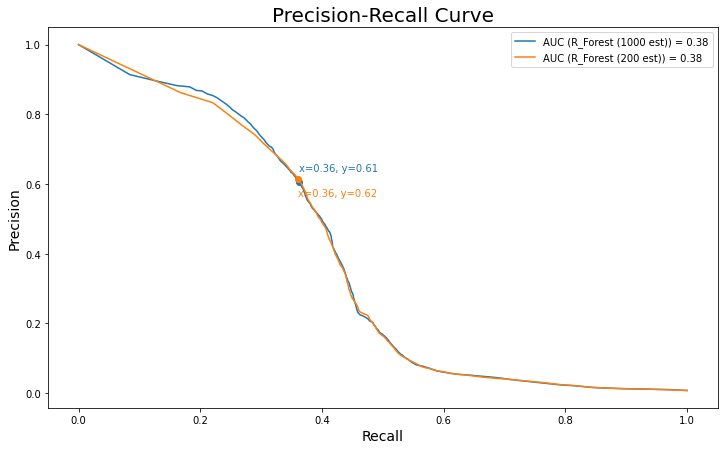

In [25]:
draw_precision_recall_curve([df_all, df_all_small], ['R_Forest (1000 y7est)', 'R_Forest (200 est)'])

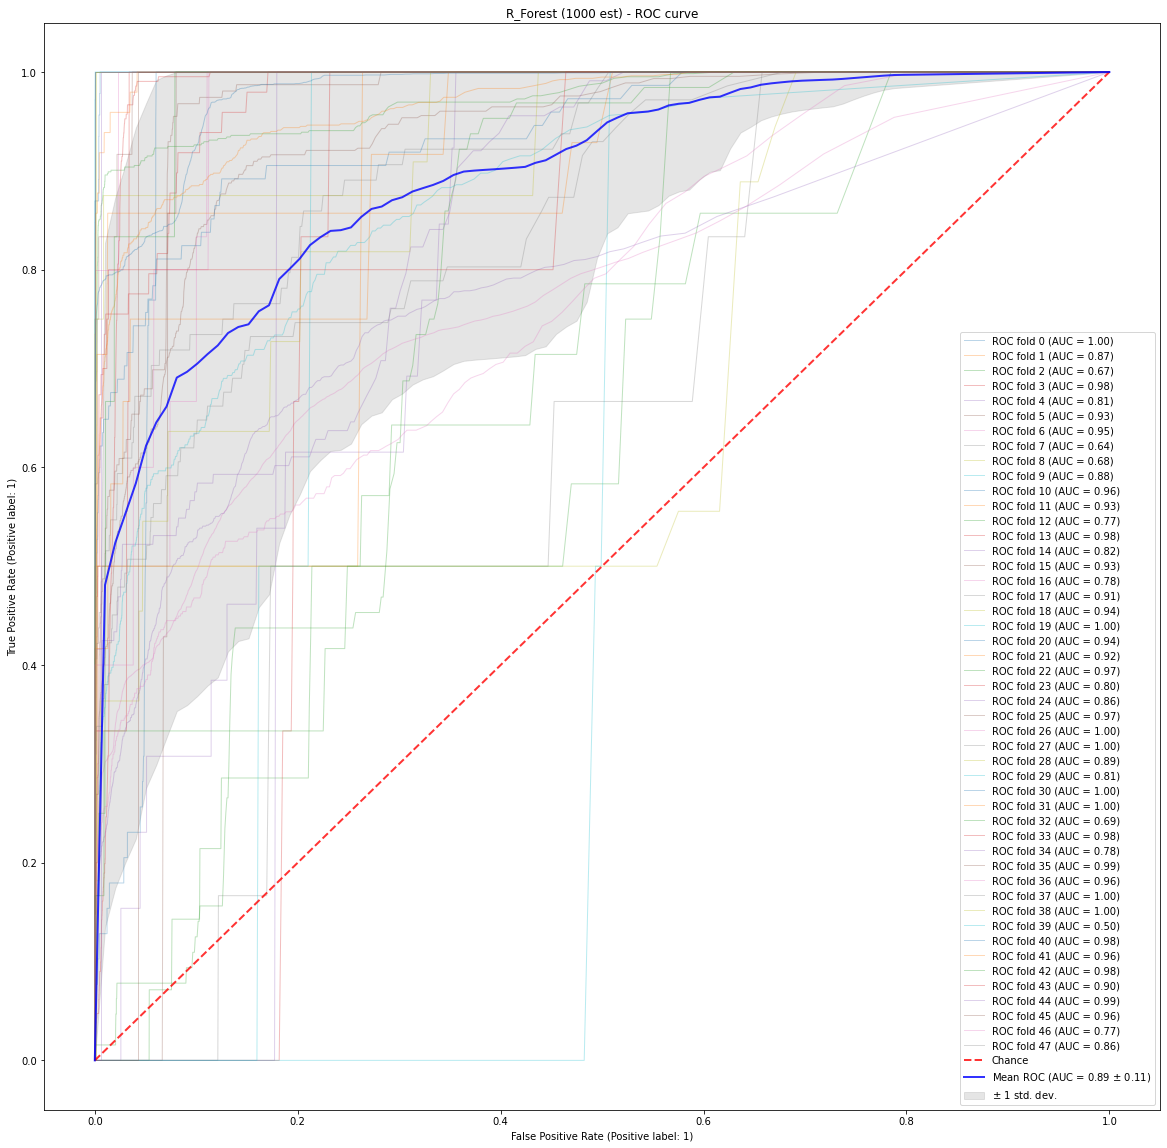

In [31]:
draw_roc_cv(df_all, 'R_Forest (1000 est)')

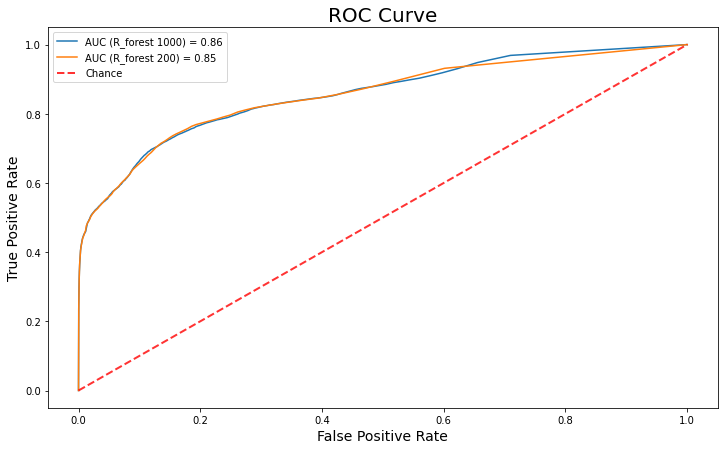

In [33]:
draw_rocs([df_all, df_all_small], ['R_forest 1000', 'R_forest 200'])

# Info on df

In [8]:
df_all.isna().any()

virus                     False
host                      False
blastn                    False
crisprdetect-2mismatch    False
gc_content                False
k25                       False
k6-chebyshev              False
k6-kendalltau             False
k6-manhattan              False
piler-2mismatch           False
wish                      False
group                      True
group_code                False
y                         False
0                         False
1                         False
dtype: bool

In [ ]:
# !!! requires Pandas 1.3.5 - incompatible with >= 1.4.0 because of indexing !!!
from pandas_profiling import ProfileReport
profile = ProfileReport(df_all.drop(['0', '1'], axis=1), title='Bacteriophage interactions (Edwards) dataset')
profile.to_file('Edwards_analysis.html')

### Determining multicollinearity

#### VIF - Variance Inflation Factor

In [5]:
# Compute VIF data for each independent variable (considered high if > 10)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = df_all.drop(['virus', 'host', '0', '1', 'group'], axis=1).columns
vif["vif_Factor"] = [variance_inflation_factor(df_all.drop(['virus', 'host', '0', '1', 'group'], axis=1).values, i) \
    for i in range(df_all.drop(['virus', 'host', '0', '1', 'group'], axis=1).shape[1])]
vif

,features,vif_Factor
0,blastn,8.871214
1,crisprdetect-2mismatch,6.662177
2,gc_content,33.409399
3,k25,8.854269
4,k6-chebyshev,4.187588
5,k6-kendalltau,54.547395
6,k6-manhattan,130.085171
7,piler-2mismatch,6.658734
8,wish,27.267813
9,group_code,4.598148


#### Variable selection

In [10]:
df_chosen = df_all[['blastn', 'gc_content', 'k6-chebyshev', 'y']]
vif_2 = pd.DataFrame()
vif_2["features"] = df_chosen.columns
vif_2["vif_Factor"] = [variance_inflation_factor(df_chosen.values, i) for i in range(df_chosen.shape[1])]
vif_2

,features,vif_Factor
0,blastn,1.127404
1,gc_content,2.668067
2,k6-chebyshev,2.669262
3,y,1.128129


#### PCA

In [23]:
from scipy.stats import shapiro
shapiro(X_main)

c:\licencjat\test_env\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.0050604939460754395, pvalue=0.0)

In [20]:
from sklearn.preprocessing import Normalizer
X_pca = Normalizer().fit_transform(X_main)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)

principal_df = pd.DataFrame(data=X_pca, columns=['component 1', \
                            'component 2'])
pca_df = pd.concat([principal_df, df_all['y']], axis=1)

Visualize PCA

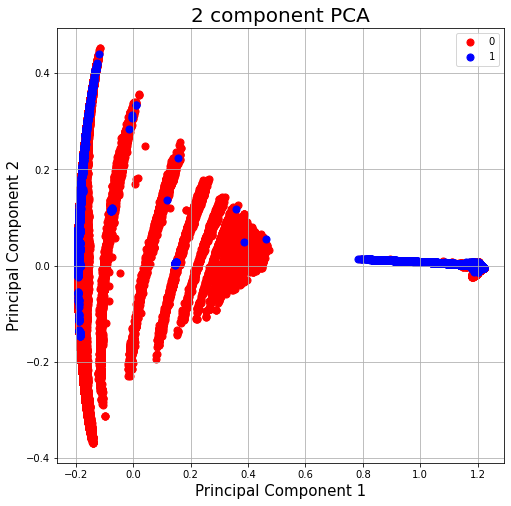

In [22]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['y'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'component 1']
               , pca_df.loc[indicesToKeep, 'component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()